<a href="https://colab.research.google.com/github/Pharaminus/Systeme-de-prechargement-des-donnees-dans-la-memoire/blob/main/Prechargement_de_donnees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install

ERROR: You must give at least one requirement to install (see "pip help install")


# **Importation des bibliotheques**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve

# **Implementation des methodes heuristiques de prefetching**

In [ ]:
class PrefetchHeuristics:
    @staticmethod
    def int_prefetch(addr):
        return [addr + 4, addr + 8, addr + 12]

    @staticmethod
    def float_prefetch(addr):
        return [addr + 8, addr + 16]

    @staticmethod
    def double_prefetch(addr):
        return [addr + 16, addr + 32]

    @staticmethod
    def char_prefetch(addr):
        return [addr + 1, addr + 2, addr + 3, addr + 4]

# **Classe pour l'entrainement du modele et sont evaluation**

In [ ]:
class ModelEvaluator:
    def __init__(self, model, scaler, X_train, X_test, y_train, y_test):
        self.model = model
        self.scaler = scaler
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

    def plot_learning_curve(self):
        train_sizes, train_scores, test_scores = learning_curve(
            self.model, self.X_train, self.y_train,
            train_sizes=np.linspace(0.1, 1.0, 10),
            cv=5
        )

        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
        plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation')
        plt.xlabel('Training Examples')
        plt.ylabel('Score')
        plt.title('Learning Curve')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_confusion_matrix(self):
        y_pred = self.model.predict(self.scaler.transform(self.X_test))
        cm = confusion_matrix(self.y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

def hex_to_int(hex_str):
    try:
        return int(str(hex_str), 16) if isinstance(hex_str, str) and '0x' in hex_str else int(hex_str)
    except ValueError:
        return 0

def train_and_evaluate_model(data_path, model_save_path='model.joblib', scaler_save_path='scaler.joblib'):
    data = pd.read_csv(data_path)

    #=========( Prétraitement )===============
    data['data_value'] = data['data_value'].apply(hex_to_int)
    data['memory_address'] = data['memory_address'].apply(hex_to_int)

    X = data[['data_value', 'memory_address', 'memory_size']]
    y = data['data_type']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    model = SVC(kernel='rbf', probability=True)
    model.fit(X_train_scaled, y_train)

    #=========( Évaluation )=========
    evaluator = ModelEvaluator(model, scaler, X_train, X_test, y_train, y_test)
    evaluator.plot_learning_curve()
    evaluator.plot_confusion_matrix()

    #=========( Cross-validation )=========
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

    #==========( Classification report  )===========
    y_pred = model.predict(scaler.transform(X_test))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    joblib.dump(model, model_save_path)
    joblib.dump(scaler, scaler_save_path)

    return model, scaler

def predict_and_prefetch(data_value, memory_address, memory_size,
                        model_path='model.joblib', scaler_path='scaler.joblib'):
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)

    data_value_int = hex_to_int(data_value)
    memory_address_int = hex_to_int(memory_address)

    features = [[data_value_int, memory_address_int, memory_size]]
    features_scaled = scaler.transform(features)

    predicted_type = model.predict(features_scaled)[0]
    probas = model.predict_proba(features_scaled)[0]

    #========( Sélection de la stratégie de prefetch )=========
    heuristics = PrefetchHeuristics()
    prefetch_addresses = []

    if predicted_type == 'int':
        prefetch_addresses = heuristics.int_prefetch(memory_address_int)
    elif predicted_type == 'float':
        prefetch_addresses = heuristics.float_prefetch(memory_address_int)
    elif predicted_type == 'double':
        prefetch_addresses = heuristics.double_prefetch(memory_address_int)
    elif predicted_type == 'char':
        prefetch_addresses = heuristics.char_prefetch(memory_address_int)

    return {
        'predicted_type': predicted_type,
        'confidence': max(probas),
        'original_address': hex(memory_address_int),
        'prefetch_addresses': [hex(addr) for addr in prefetch_addresses]
    }




# **Entraînement et évaluation**

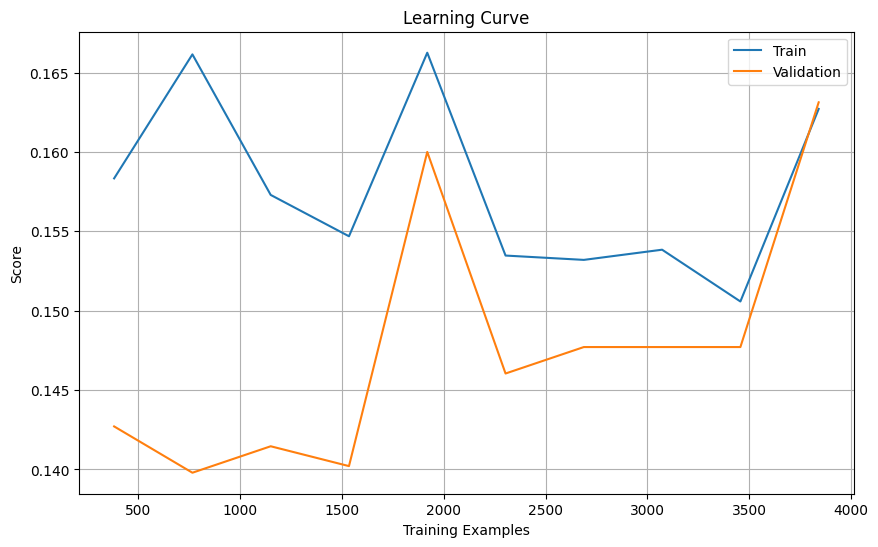

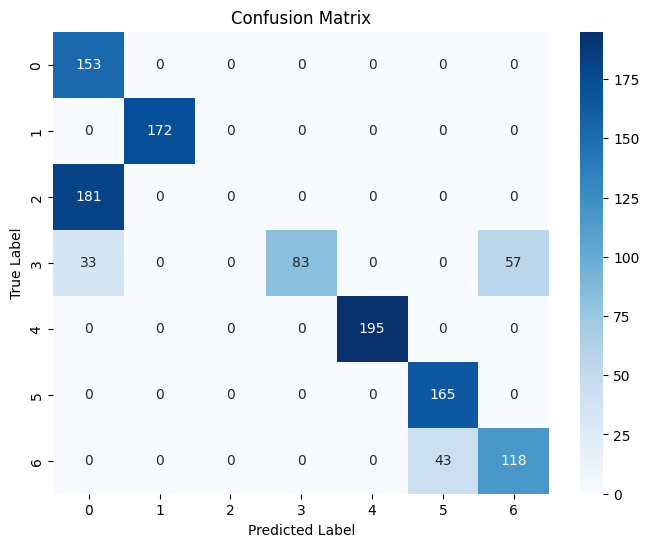

Cross-validation scores: [0.740625   0.74791667 0.75       0.74166667 0.74479167]
Mean CV score: 0.745 (+/- 0.007)

Classification Report:
              precision    recall  f1-score   support

 defaultdict       0.42      1.00      0.59       153
       deque       1.00      1.00      1.00       172
        dict       0.00      0.00      0.00       181
        list       1.00      0.48      0.65       173
         set       1.00      1.00      1.00       195
      string       0.79      1.00      0.88       165
       tuple       0.67      0.73      0.70       161

    accuracy                           0.74      1200
   macro avg       0.70      0.74      0.69      1200
weighted avg       0.70      0.74      0.69      1200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
model, scaler = train_and_evaluate_model('donnees.csv')

In [ ]:
# Test de prédiction et prefetching
result = predict_and_prefetch(
    data_value= "bonjour la famille comment allez vous ?",
    memory_address='0x5000',
    memory_size=8
)

print("\n======================================================\n")
print("=             Résultats de la prédiction             =\n")
print("======================================================\n")

print(f"========(  Type prédit: {result['predicted_type']}\n")
print("---------------------------------------------------------")
print(f"========(  Confiance: {result['confidence']:.2%} \n")
print("---------------------------------------------------------")
print(f"========(  Adresse originale: {result['original_address']}\n")
print("---------------------------------------------------------")
print(f"========(  Adresses à précharger: {result['prefetch_addresses']}\n")



=             Résultats de la prédiction             =


========(  Type prédit: string

---------------------------------------------------------
========(  Confiance: 58.72% 

---------------------------------------------------------
========(  Adresse originale: 0x5000

---------------------------------------------------------
========(  Adresses à précharger: []



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
import joblib
import os

# **Fonction pour la sauvegarde du modele.**

Fonc

In [ ]:
def save_model(model, scaler, metrics, save_dir='model_files'):
    """
    Sauvegarde le modèle et ses composants
    """
    os.makedirs(save_dir, exist_ok=True)

    model_components = {
        'model': model,
        'scaler': scaler,
        'metrics': metrics
    }

    save_path = os.path.join(save_dir, 'model_components.joblib')
    joblib.dump(model_components, save_path)
    return save_path

# **Fonction pour charger le modele**

In [ ]:
def load_model(model_path):
    """
    Charge le modèle et ses composants
    """
    model_components = joblib.load(model_path)
    return model_components['model'], model_components['scaler'], model_components['metrics']

# Exemple d'utilisation
if __name__ == "__main__":
    # Après entraînement
    metrics = {
        'accuracy': 0.95,
        'cross_val_scores': [0.94, 0.95, 0.93],
        'training_date': '2024-01-01'
    }

    # Sauvegarder
    save_path = save_model(model, scaler, metrics)

    # Charger
    loaded_model, loaded_scaler, loaded_metrics = load_model(save_path)